# Baseline Model: XGBoost
In this notebook, we forecast the fastest Bitcoin transaction fee (sats/vByte) using XGBoost Regressor. 

### Why We Chose XGBoost as a Baseline Model
We selected XGBoost as one of our baseline models because it provides a strong balance between performance, interpretability, and efficiency when working with structured tabular data. Unlike traditional linear models, XGBoost can effectively capture non-linear relationships and complex interactions between features, which includes both temporal patterns (via lag features) and contextual signals (like mempool and market conditions). 

Our target variable recommended_fee_fastestFee is not only time-dependent but also correlates with other recommended fee rates (e.g., halfHourFee, hourFee, etc.), which serve as important external features. When there are known correlations between the target and input features in the presence of redundancy or nonlinearity, XGBoost offers both high performance and interpretability. The exploratory data analysis confirms these relationships and reveals substantial variability and temporal structure in the data, which makes simpler linear models less effective. XGBoost, in contrast, is robust to multicollinearity, handles missing data gracefully, and naturally incorporates lag features. Additionally, it provides useful feature importance insights and performs well with minimal preprocessing, which makes it a practical and reliable starting point for benchmarking more complex forecasting models.

By tuning key hyperparameters and evaluating the model with MAE and RMSE, we can gauge how well tree-based methods handle fee rate prediction and set a meaningful performance benchmark.


### Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib  
from scipy.stats import uniform, randint
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import seaborn as sns
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import temporal_train_test_split, ForecastingRandomizedSearchCV
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_error as mean_absolute_error_sktime
from sktime.split import SlidingWindowSplitter

In [ ]:
import sys
sys.path.append("../src")
from XGBoost import data_split, build_random_search, create_lag_features_fast,evaluate_model,plot_result,evaluate_best_model
from preprocess_raw_parquet import preprocess_raw_parquet

### Load data
To ensure that we only train on complete data, we drop the lag rows which contain NaN values introduced by lag feature creation. Because of spikes in the last day, we remove the last 24-hour from the dataset.

In [ ]:
df = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")
df.dropna(inplace = True)
df.head()

### Create lag features

We will need lagging feature for XGboost. Since each hour has 4 data points (60 ÷ 15), 48 hours = 192 lag steps.

In [ ]:
lags = range(1, 193)  # 48 hours of 15-minute intervals
df = create_lag_features_fast(df, 'recommended_fee_fastestFee', lags)
df.head()

## Optimization - Find the best params

### Params
We choose RandomizedSearch to optimize the model. It allows us to explore a broader space efficiently with fewer iterations. Here are the ranges of parameters.

n_estimators: [50, 100, 150] 
It controls the number of boosting rounds. Small values (50) may underfit, while higher values (150) may lead to better performance but risk overfitting. Keeping this modest helps reduce training time and keeps the search space focused.

max_depth: [1, 2, 3] 
It controls the maximum depth of individual trees. Shallow trees (1–3) are less likely to overfit and are more interpretable. Especially appropriate when the number of features is high and the time resolution is short (5-min data), helping avoid overly complex trees.

learning_rate: [0.01, 0.05, 0.1] 
Learning rate shrinks the contribution of each tree. Lower values slow down learning but improve generalization. Chosen to strike a balance between convergence speed and model stability.

subsample: [0.6, 0.8, 0.9] 
Fraction of rows used per tree. It introduces randomness ,helping prevent overfitting and improving robustness. 0.6–0.9 allows experimentation with more regularized models.

colsample_bytree: [0.6, 0.8, 0.9] 
Fraction of columns (features) used to build each tree. Especially helpful when there are many features. It helps prevent overfitting by decorrelating trees.

gamma: [1, 3, 5] 
Minimum loss reduction to make a split. It acts as a regularizer to control tree growth. Higher values force the model to make only meaningful splits.

reg_lambda: [5, 10, 20] 
L2 regularization on leaf weights. It prevents overly large weights, stabilizing the model especially with correlated features. It also helps handle multicollinearity and improve generalization.

reg_alpha: [5, 10, 20] 
L1 regularization (sparsity). It encourages feature selection by zeroing out less useful ones, and is particularly useful in high-dimensional datasets (e.g., many lag features).

In [ ]:
param_dist = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [1, 2, 3],
    'estimator__learning_rate': [0.01, 0.05, 0.1],
    'estimator__subsample': [0.6, 0.8, 0.9],
    'estimator__colsample_bytree': [0.6, 0.8, 0.9],
    'estimator__gamma': [1, 3, 5],
    'estimator__reg_lambda': [5, 10, 20],
    'estimator__reg_alpha': [5, 10, 20]
}


In [6]:
def mae_with_std_and_shape_penalty(y_true, y_pred, std_weight=1.0, de_weight=1.0, clip_weight_std=None, clip_weight_dev=None):
    """
    Compute custom MAE loss with additional penalties on std deviation and shape deviation.

    Parameters:
        y_true: np.ndarray, ground truth values
        y_pred: np.ndarray, predicted values
        std_weight: float, weight for std penalty
        de_weight: float, weight for shape deviation penalty
        clip_weight_std: float or None, optional max clip value for std penalty weight
        clip_weight_dev: float or None, optional max clip value for shape deviation weight

    Returns:
        float: combined loss
    """

    # y_true = np.array(y_true)
    # y_pred = np.array(y_pred)

    # base_loss = np.abs(y_pred - y_true)
    # base_mae = np.mean(base_loss)

    # # ---- STD penalty ----
    # pred_std = np.std(y_pred)
    # true_std = np.std(y_true)
    # std_penalty = np.abs(pred_std - true_std)
    # w_std = base_mae / (std_penalty + 1e-8)
    # if clip_weight_std is not None:
    #     w_std = min(w_std, clip_weight_std)

    # # ---- Shape deviation penalty ----
    # pred_dev = y_pred - np.mean(y_pred)
    # true_dev = y_true - np.mean(y_true)
    # dev_error = np.abs(pred_dev - true_dev)
    # w_dev = base_loss / (dev_error + 1e-8)
    # if clip_weight_dev is not None:
    #     w_dev = np.clip(w_dev, None, clip_weight_dev)

    # # Final loss
    # shape_penalty = np.mean(w_dev * dev_error)
    # total_loss = base_mae + std_weight * w_std * std_penalty + de_weight * shape_penalty

    # return total_loss
    base_loss = np.abs(y_pred - y_true)
    mae = base_loss.mean()

    # Std penalty
    pred_std = np.std(y_pred)
    true_std = np.std(y_true)
    std_penalty = np.abs(pred_std - true_std)

    w_std = mae / (std_penalty + 1e-8)
    if clip_weight_std is not None:
        w_std = np.minimum(w_std, clip_weight_std)

    # Deviation penalty
    pred_mean = np.mean(y_pred)
    true_mean = np.mean(y_true)
    pred_dev = y_pred - pred_mean
    true_dev = y_true - true_mean
    dev_error = np.abs(pred_dev - true_dev)

    w_dev = base_loss / (dev_error + 1e-8)
    if clip_weight_dev is not None:
        w_dev = np.minimum(w_dev, clip_weight_dev)

    # Total loss
    total_loss = base_loss + std_weight * w_std * std_penalty + de_weight * w_dev * dev_error
    return total_loss.mean()

### Sliding window

The dataset contains 10-week data. Use each of the five weeks data to train the model. Fixed-size window helps assess how well model generalizes across changing conditions.

In [ ]:
fh = ForecastingHorizon(np.arange(1, 97), is_relative=True)

In [ ]:
metrics_per_week, avg_metrics,y_test,y_pred = evaluate_model(df,param_dist,interval=15,weeks=10,fh=fh,sliding=1)

In [ ]:
print("\nAverage metrics over all weeks:")
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

### Plot 

We plot the predicted fee rates and the actual ones. 

In [ ]:
plot_result(y_test=y_test,y_pred=y_pred)

## Expanding window

The dataset contains 10-week data. Start with the first week and train the model five times by progressively adding one more week each time. This methods simulates real-world scenario as more historical data becomes available and tests whether model improves as it learns from a growing dataset. 

In [ ]:
metrics_per_week, avg_metrics,y_test,y_pred = evaluate_model(df,param_dist,interval=15,weeks=10,fh=fh,sliding=0)

In [ ]:
print("\nAverage metrics over all weeks:")
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

### Plot 

We plot the predicted fee rates and the actual ones. 

In [ ]:
plot_result(y_test=y_test,y_pred=y_pred)

### The best model

Fianlly, we try to train with expanding window on the whole data set. Because of spikes in the last day, we remove the last 24-hour from the dataset.

In [ ]:
df_new = df.iloc[:-96]

In [ ]:
metrics,y_test,y_pred = evaluate_best_model(df,param_dist,15,fh)

In [ ]:
print("\nMetrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

### Plot

In [ ]:
plot_result(y_test=y_test,y_pred=y_pred)

### The best model

Fianlly, we try to train with expanding window on the whole data set. Because of spikes in the last day, we remove the last 24-hour from the dataset.

In [7]:
df_new = df.iloc[:-96]

In [11]:
X_train, X_test, y_train, y_test = data_split(df_new,15)
random_search = build_random_search(y_train, param_dist,15,0)  # 0 = expanding window
random_search.fit(X=X_train, y=y_train,fh=fh)
best_forecaster = random_search.best_forecaster_
print("Best parameters (MAE):", random_search.best_params_)

y_pred_temp = best_forecaster.predict(fh=fh,X=X_test)
y_pred_temp.index =X_test.index

y_baseline = [y_train.median()] * len(y_test)

mae = mean_absolute_error(y_test, y_pred_temp)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_temp))
mape = mean_absolute_percentage_error(y_test, y_pred_temp)
mae_std = mae_with_std_and_shape_penalty(y_test, y_pred_temp)

base_mae = mean_absolute_error(y_test, y_baseline)
base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))
base_mape = mean_absolute_percentage_error(y_test, y_baseline)   
base_mae_std = mae_with_std_and_shape_penalty(y_test, y_baseline)


Fitting 1 folds for each of 20 candidates, totalling 20 fits
Best parameters (MAE): {'estimator__subsample': 0.6, 'estimator__reg_lambda': 10, 'estimator__reg_alpha': 20, 'estimator__n_estimators': 100, 'estimator__max_depth': 1, 'estimator__learning_rate': 0.1, 'estimator__gamma': 5, 'estimator__colsample_bytree': 0.9}


In [12]:
print(f"Baseline MAE: {base_mae:.4f}")
print(f"Baseline RMSE: {base_rmse:.4f}")
print(f"Baseline MAPE: {base_mape:.4f}")
print(f"Baseline MAE with std and shape penelty: {base_mae_std:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"MAE with std and shape penalty: {mae_std:.4f}")

Baseline MAE: 0.9097
Baseline RMSE: 1.1087
Baseline MAPE: 0.5078
Baseline MAE with std and shape penelty: 2.7292
MAE: 0.7486
RMSE: 1.0072
MAPE: 0.3687
MAE with std and shape penalty: 2.2458


### Plot

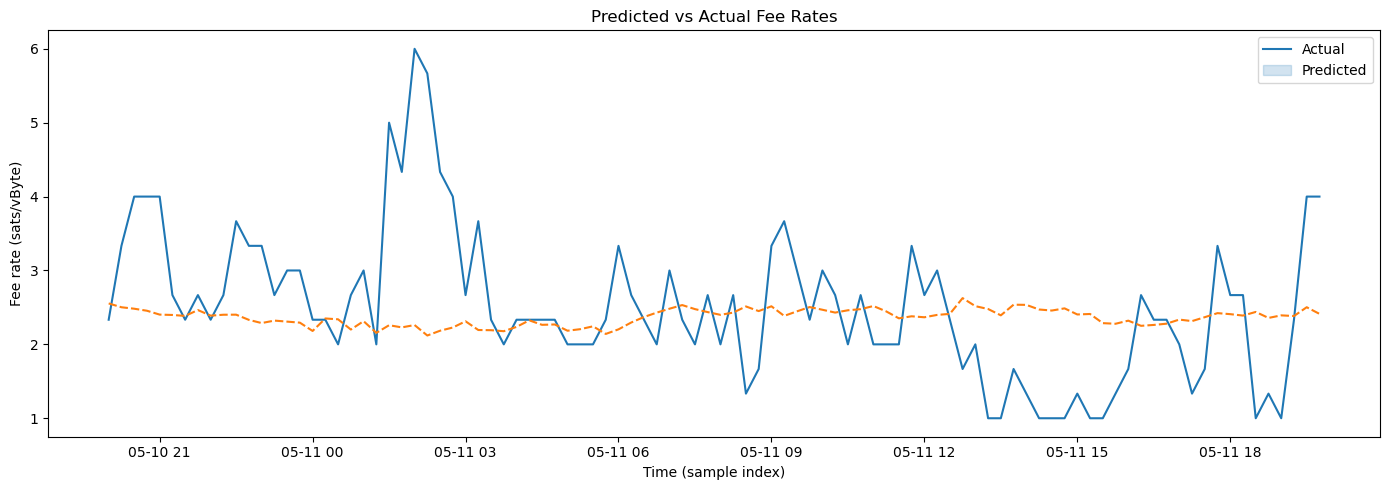

In [13]:
result_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_temp
}, index=y_test.index)

plt.figure(figsize=(14, 5))
sns.lineplot(data=result_df)
plt.title('Predicted vs Actual Fee Rates')
plt.xlabel('Time (sample index)')
plt.ylabel('Fee rate (sats/vByte)')
plt.legend(['Actual', 'Predicted'])
plt.tight_layout()
plt.show()

### Conclusion

Based on the average metrics, expanding window performs better than sliding window across all metrics. Moreover, it slightly outperforms baseline (i.e. global median) within the 5-weeks data available. However, the performance is still far from ideal.